Example: Windowed Gaussian Process transition model with insect walk path data

Compare performance between 
- fixed hyperparameters sliding window GP model (length scale, output var)
- online hyp GP model
- constant velocity model

In [98]:
# define constants

from sklearn.gaussian_process.kernels import RBF
import numpy as np
from datetime import datetime, timedelta

PRIOR_SCALE = 10
WINDOW_SIZE = 10
TIME_INTERVAL = timedelta(seconds=1)

KERNEL_LENGTH_SCALE = 10
KERNEL_OUT_VAR = 30

CV_NOISE_DIFF_COEFF = 0.1

NOISE_COVAR = 2
PRIOR_COVAR = 1
num_steps = 100

np.random.seed(0)

In [99]:
# Define our 2D transition model
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)
print(os.listdir(parent_dir))

from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, \
                                               SlidingWindowGaussianProcess
from stonesoup.base import Property

# Sliding window GP with RBF kernel
class RBFKernelGP(SlidingWindowGaussianProcess):

    length_scale: float = Property()
    output_var: float = Property()

    def kernel(self, x, y, **kwargs):
        k = RBF(self.length_scale)
        return self.output_var * k(x,y)

transition_model = CombinedLinearGaussianTransitionModel([RBFKernelGP(window_size=WINDOW_SIZE, length_scale=KERNEL_LENGTH_SCALE, output_var=KERNEL_OUT_VAR),
                                                          RBFKernelGP(window_size=WINDOW_SIZE, length_scale=KERNEL_LENGTH_SCALE, output_var=KERNEL_OUT_VAR)])

['.circleci', '.codecov.yml', '.flake8', '.git', '.gitattributes', '.github', '.gitignore', '.git_archival.txt', '.pytest_cache', '.readthedocs.yml', '01_KalmanFilterTutorial (1).ipynb', '06_DataAssociation-MultiTargetTutorial.ipynb', 'binder', 'CITATION.cff', 'dataset_InsectFlightDynamics', 'docs', 'example_IWGP.py', 'example_WGP.py', 'InsectFlightDynamics_Sec1.ipynb', 'LICENSE', 'MANIFEST.in', 'notebooks', 'pyproject.toml', 'README.md', 'sec1.ipynb', 'sec1_cattle.ipynb', 'sec1_extra.ipynb', 'sec1_gp_generated.ipynb', 'sec1_gp_generated_single.ipynb', 'sec1_gp_prior.ipynb', 'sec1_hyp_optim.ipynb', 'sec2_igp_generated copy.ipynb', 'sec2_random.ipynb', 'sec3_dynamic_gp.ipynb', 'stonesoup', 'tractmethod', 'X and Y.', '__pycache__']


In [100]:
# Obtain ground truth coordinates from insect walk data

from get_coordinates import get_coordinates
import pandas as pd

# Load the CSV file into a DataFrame
file_path = 'Coordinate_second.csv'  # Replace with the actual file path
df = pd.read_csv(file_path)

# Extract all coordinates
type_name = 'Dmelanogaster' # 'Calocasiae' # 'Dmelanogaster'
movie_number = 1
fly_number = 5
x, y = get_coordinates(df, type_name, movie_number, fly_number)

In [101]:
# Convert raw coordiantes to ground truth path

from stonesoup.types.groundtruth import GroundTruthPath, GroundTruthState
from stonesoup.types.state import GaussianState, StateVector

start_time = datetime.now().replace(microsecond=0) 
curr_time = start_time + (WINDOW_SIZE-1) * TIME_INTERVAL  # first prediction at t = 5

truth = GroundTruthPath()

# Generate path
for k in range(num_steps+1):
    truth.append(GroundTruthState(np.concatenate((np.flip(x[k:WINDOW_SIZE+k]), np.flip(y[k:WINDOW_SIZE+k]))), timestamp=curr_time))
    curr_time += TIME_INTERVAL


In [102]:
# Simulate gaussian noise measurements
from stonesoup.types.detection import Detection
from stonesoup.models.measurement.linear import LinearGaussian

# Define measurement model
measurement_model = LinearGaussian(
    ndim_state=WINDOW_SIZE*2,
    mapping=(0, WINDOW_SIZE),
    noise_covar=np.array([[NOISE_COVAR, 0],
                          [0, NOISE_COVAR]])
    )

# Generate measurements
measurements = []
for state in truth:
    measurement = measurement_model.function(state, noise=True)
    measurements.append(Detection(measurement,
                                  timestamp=state.timestamp,
                                  measurement_model=measurement_model))

In [103]:
# Plot ground truth and simulated measurements

from stonesoup.plotter import AnimatedPlotterly

timesteps = [start_time + TIME_INTERVAL * i for i in range(num_steps + WINDOW_SIZE)]

plotter = AnimatedPlotterly(timesteps, tail_length=1)
plotter.plot_ground_truths(truth, [0, WINDOW_SIZE])
plotter.plot_measurements(measurements, [0, WINDOW_SIZE])
plotter.fig

In [104]:
# Initialise predictor and prior for kalman filtering

from stonesoup.predictor.kalman import KalmanPredictor

predictor = KalmanPredictor(transition_model)

prior_state_vector = np.zeros(WINDOW_SIZE*2)
prior_state_vector[:WINDOW_SIZE] += x[0]
prior_state_vector[WINDOW_SIZE:] += y[0]
prior = GaussianState(StateVector(prior_state_vector), np.identity(WINDOW_SIZE*2)*PRIOR_COVAR, timestamp=truth[0].timestamp)

In [105]:
from scipy.linalg import inv
from scipy.optimize import minimize
from stonesoup.types.prediction import GaussianStatePrediction
from stonesoup.updater.kalman import KalmanUpdater
from stonesoup.types.hypothesis import SingleHypothesis

def optimise_length_scale(length_scale, output_var, prior: GaussianStatePrediction, pred_time, obs_matrix, obs_covar, y):
    # create model with length scale to be modified
    gp_model = RBFKernelGP(window_size=WINDOW_SIZE, length_scale=length_scale, output_var=output_var)
    predictor = KalmanPredictor(gp_model)

    # this needs to be a fcn of length_scale ie compute using RBF kernel
    def kalman_predictive_likelihood(length_scale, prior, pred_time, H, Cv, y):
        # print('Evaluating likelihood for length scale:', length_scale)

        # say prior at time t - 1
        # we pred for time t
        # we need measurements (y) from time = t-L+1 to t to cover entiree tstatevector at time t.

        log_likelihood = 0

        # modify length scale of model
        predictor.transition_model.length_scale = length_scale
        # print(length_scale)

        for i in range(1):  # do this for one timestep for now
            # y = prev_measurements[i]  # most recent last
            
            # prediction step
            # disabled predict_lru_cache for this. how to fix?
            # pass in length_scale through kwargs/normal arg instead of a model property? - can't have different length scales for x and y coors
            # use lru clear cache thing?

            state_pred = predictor.predict(prior, pred_time=pred_time, timestamp=prior.timestamp+timedelta(seconds=1))  # need to attach timestamp to prior and pass in as argument to calc time_interval
            m_pred = state_pred.state_vector
            P_pred = state_pred.covar
 
            S = H @ P_pred @ H.T + Cv  # Innovation covariance
            sign, logdet = np.linalg.slogdet(S)  # prevent numericla instabiltiy when inverting then taking log
            log_likelihood += -0.5 * (logdet +
                                      (y - H @ m_pred).T @ inv(S) @ (y - H @ m_pred))
            # print(log_likelihood)
            
        return -log_likelihood

    res = minimize(kalman_predictive_likelihood, x0=length_scale, 
                   args=(prior, pred_time, obs_matrix, obs_covar, y),
                   bounds=[(1,100)],  method="Nelder-Mead")

    return res.x[0]

def optimise_output_var(length_scale, output_var, prior: GaussianStatePrediction, pred_time, obs_matrix, obs_covar, y):
    # create model with length scale to be modified
    gp_model = RBFKernelGP(window_size=WINDOW_SIZE, length_scale=length_scale, output_var=output_var)
    predictor = KalmanPredictor(gp_model)

    def kalman_predictive_likelihood(output_var, prior, pred_time, H, Cv, y):
        log_likelihood = 0

        # modify length scale of model
        predictor.transition_model.output_var = output_var

        state_pred = predictor.predict(prior, pred_time=pred_time, timestamp=prior.timestamp+timedelta(seconds=1))  # need to attach timestamp to prior and pass in as argument to calc time_interval
        m_pred = state_pred.state_vector
        P_pred = state_pred.covar

        S = H @ P_pred @ H.T + Cv  # Innovation covariance
        sign, logdet = np.linalg.slogdet(S)  # prevent numericla instabiltiy when inverting then taking log
        log_likelihood += -0.5 * (logdet +
                                    (y - H @ m_pred).T @ inv(S) @ (y - H @ m_pred))
        # print(log_likelihood)
            
        return -log_likelihood

    res = minimize(kalman_predictive_likelihood, x0=output_var, 
                   args=(prior, pred_time, obs_matrix, obs_covar, y),
                   bounds=[(1,100)],  method="Nelder-Mead")

    return res.x[0]

In [106]:
# Set up constant velocity model
from stonesoup.models.transition.linear import ConstantVelocity

# measurements
measurement_model_cv = LinearGaussian(
    ndim_state=4,  # Assume 2D model
    mapping=(0, 2),  # Mapping measurement vector index to state index
    noise_covar=np.array([[NOISE_COVAR, 0],  # Covariance matrix for Gaussian PDF
                          [0, NOISE_COVAR]])
    )

measurements_cv = []
for i in range(len(measurements)):
    measurement = measurements[i]
    measurements_cv.append(Detection(measurement.state_vector,
                                  timestamp=measurement.timestamp,
                                  measurement_model=measurement_model_cv))
    
# Kalman predictor
transition_model_cv = CombinedLinearGaussianTransitionModel([ConstantVelocity(CV_NOISE_DIFF_COEFF),
                                                             ConstantVelocity(CV_NOISE_DIFF_COEFF)])

predictor_cv = KalmanPredictor(transition_model_cv)

# Prior (first pred at t=5, so prior at t=4)
prior_cv = GaussianState([[x[WINDOW_SIZE-1]], [1], [y[WINDOW_SIZE-1]], [1]], np.diag([1.5, 0.5, 1.5, 0.5]), timestamp=truth[0].timestamp)

# Updater
updater_cv = KalmanUpdater(measurement_model_cv)


In [107]:
# Set up fixed hyp GP model
transition_model_fixed = CombinedLinearGaussianTransitionModel([RBFKernelGP(window_size=WINDOW_SIZE, length_scale=KERNEL_LENGTH_SCALE, output_var=KERNEL_OUT_VAR),
                                                                RBFKernelGP(window_size=WINDOW_SIZE, length_scale=KERNEL_LENGTH_SCALE, output_var=KERNEL_OUT_VAR)])

predictor_fixed = KalmanPredictor(transition_model_fixed)
prior_fixed = prior

In [108]:
# # Kalman filtering: Prediction and update steps

from stonesoup.types.hypothesis import SingleHypothesis
from stonesoup.types.track import Track
from stonesoup.updater.kalman import KalmanUpdater

# updater = KalmanUpdater(measurement_model)
# track = Track()
# track.append(prior)

# track_fixed = Track()
# track_fixed.append(prior)
# track_cv = Track()
# track_cv.append(prior_cv)

# L = WINDOW_SIZE
# H = measurement_model_gp_1d.matrix()
# Cv = measurement_model_gp_1d.covar()
# length_scale_x, length_scale_y = KERNEL_LENGTH_SCALE, KERNEL_LENGTH_SCALE
# output_var_x, output_var_y = KERNEL_OUT_VAR, KERNEL_OUT_VAR

# for i in range(1, len(measurements)):
#     measurement = measurements[i]
#     prediction = predictor.predict(prior, timestamp=measurement.timestamp, pred_time=(measurement.timestamp-start_time))
#     hypothesis = SingleHypothesis(prediction, measurement)
#     post = updater.update(hypothesis)
#     track.append(post)

#     measurement_cv = measurements_cv[i]
#     prediction_fixed = predictor_fixed.predict(prior_fixed, timestamp=measurement.timestamp,pred_time=(measurement.timestamp-start_time))
#     prediction_cv = predictor_cv.predict(prior_cv, timestamp=measurement.timestamp)
#     hypothesis_fixed = SingleHypothesis(prediction_fixed, measurement)
#     hypothesis_cv = SingleHypothesis(prediction_cv, measurement_cv)
#     post_fixed = updater.update(hypothesis_fixed)
#     post_cv = updater_cv.update(hypothesis_cv)
#     track_fixed.append(post_fixed)
#     track_cv.append(post_cv)
#     prior_fixed=track_fixed[-1]
#     prior_cv=track_cv[-1]

#     # update length scales
#     current_x = measurement.state_vector[0]
#     current_y = measurement.state_vector[1]
#     pred_time = measurement.timestamp - start_time
#     prediction_x = GaussianStatePrediction(prior.state_vector[:L], prior.covar[:L,:L], timestamp=measurement.timestamp)
#     prediction_y = GaussianStatePrediction(prior.state_vector[L:], prior.covar[L:,L:], timestamp=measurement.timestamp)
#     length_scale_x_new = optimise_length_scale(length_scale_x, output_var_x, prediction_x, pred_time, H, Cv, current_x)
#     length_scale_y_new = optimise_length_scale(length_scale_y, output_var_y, prediction_y, pred_time, H, Cv, current_y)
#     length_scale_x = 0.5*length_scale_x + 0.5*length_scale_x_new
#     length_scale_y = 0.5*length_scale_y + 0.5*length_scale_y_new

#     print('Updated length scales (x and y): ', length_scale_x, length_scale_y)

#     # update output vars
#     output_var_x_new = optimise_output_var(length_scale_x, output_var_x, prediction_x, pred_time, H, Cv, current_x)
#     output_var_y_new = optimise_output_var(length_scale_y, output_var_y, prediction_y, pred_time, H, Cv, current_y)
#     output_var_x = 0.5 * output_var_x + 0.5 * output_var_x_new
#     output_var_y = 0.5 * output_var_y + 0.5 * output_var_y_new

#     # Update the predictor's kernel parameters
#     predictor.transition_model.model_list[0].length_scale = length_scale_x
#     predictor.transition_model.model_list[0].output_variance = output_var_x
#     predictor.transition_model.model_list[1].length_scale = length_scale_y
#     predictor.transition_model.model_list[1].output_variance = output_var_y
#     print('Output variances (x, y): ', output_var_x, output_var_y)

#     prior = track[-1]

# # zero division error if prior.timestamp == measurement.timestamp

In [109]:
# REFACTORED CODE for abbove section

def optimise_kernel_parameters(coord, prior, measurement, kernel_params, pred_time, measurement_model):
    """
    Optimize kernel parameters (length scale and output variance) for a given coordinate.
    
    Parameters:
        coord: 'x' or 'y' (indicates which coordinate to optimize for).
        prior: Prior state.
        measurement: Current measurement.
        kernel_params: Dictionary containing kernel parameters.
        pred_time: Time since the start for prediction.
        measurement_model: Measurement model.
    
    Returns:
        Updated kernel parameters for the given coordinate.
    """
    L = len(prior.state_vector) // 2
    idx = 0 if coord == 'x' else L
    idx_measurement = 0 if coord == 'x' else 1
    current_value = measurement.state_vector[idx_measurement]
    prediction = GaussianStatePrediction(
        prior.state_vector[idx:idx+L], prior.covar[idx:idx+L, idx:idx+L], timestamp=measurement.timestamp
    )
    
    # Update length scale
    kernel_params[f'length_scale_{coord}'] = 0.5 * kernel_params[f'length_scale_{coord}'] + 0.5 * optimise_length_scale(
        kernel_params[f'length_scale_{coord}'], kernel_params[f'output_var_{coord}'], 
        prediction, pred_time, measurement_model.matrix(), measurement_model.covar(), current_value
    )
    
    # Update output variance
    kernel_params[f'output_var_{coord}'] = 0.5 * kernel_params[f'output_var_{coord}'] + 0.5 * optimise_output_var(
        kernel_params[f'length_scale_{coord}'], kernel_params[f'output_var_{coord}'], 
        prediction, pred_time, measurement_model.matrix(), measurement_model.covar(), current_value
    )
    
    return kernel_params

def update_kernel_parameters(predictor, prior, measurement, kernel_params, pred_time, measurement_model):
    """
    Update kernel parameters for both x and y coordinates.
    """
    for coord in ['x', 'y']:
        kernel_params = optimise_kernel_parameters(coord, prior, measurement, kernel_params, pred_time, measurement_model)
    
    # Update predictor's kernel parameters
    predictor.transition_model.model_list[0].length_scale = kernel_params['length_scale_x']
    predictor.transition_model.model_list[0].output_variance = kernel_params['output_var_x']
    predictor.transition_model.model_list[1].length_scale = kernel_params['length_scale_y']
    predictor.transition_model.model_list[1].output_variance = kernel_params['output_var_y']
    
    return kernel_params


def update_track(updater, track, predictor, prior, measurement, measurement_model, tune_hyperparameters=False, kernel_params=None):
    """
    Update a track with a new measurement and optionally optimize kernel parameters.
    
    Parameters:
        updater: KalmanUpdater
        track: Track to update
        predictor: Predictor to generate predictions
        prior: Prior state
        measurement: Current measurement
        measurement_model: Measurement model
        tune_hyperparameters: Whether to optimize kernel parameters (default False).
        kernel_params: Dictionary containing kernel parameters (required if tuning).
    
    Returns:
        Updated prior and kernel parameters (if tuning enabled).
    """
    # Prediction and update step
    prediction = predictor.predict(
        prior, timestamp=measurement.timestamp, pred_time=(measurement.timestamp - start_time)
    )
    hypothesis = SingleHypothesis(prediction, measurement)
    post = updater.update(hypothesis)
    track.append(post)
    
    if tune_hyperparameters and kernel_params:
        pred_time = measurement.timestamp - start_time
        kernel_params = update_kernel_parameters(predictor, prior, measurement, kernel_params, pred_time, measurement_model)
        return track[-1], kernel_params
    else:
        return track[-1], None

In [110]:
measurement_model_gp_1d = LinearGaussian(
    ndim_state=WINDOW_SIZE,  # Assume 2D model
    mapping=([0]),  # Mapping measurement vector index to state index
    noise_covar=np.array([[NOISE_COVAR]])
    )

updater = KalmanUpdater(measurement_model)

# initialise tracks
track_adaptive = Track()
track_adaptive.append(prior)
prior_adaptive = prior

track_fixed = Track()
track_fixed.append(prior_fixed)

track_cv = Track()
track_cv.append(prior_cv)

# Initialize kernel parameters for the first model
kernel_params = {
    'length_scale_x': KERNEL_LENGTH_SCALE,
    'length_scale_y': KERNEL_LENGTH_SCALE,
    'output_var_x': KERNEL_OUT_VAR,
    'output_var_y': KERNEL_OUT_VAR
}

# Process measurements
for i in range(1, len(measurements)):
    # Update the adaptive model
    prior_adaptive, kernel_params_adaptive = update_track(
        updater, track_adaptive, predictor, prior_adaptive, 
        measurements[i], measurement_model_gp_1d, tune_hyperparameters=True, kernel_params=kernel_params
    )
    
    # Update the fixed model
    prior_fixed, _ = update_track(
        updater, track_fixed, predictor_fixed, prior_fixed, 
        measurements[i], measurement_model_gp_1d, tune_hyperparameters=False
    )
    
    # Update the constant velocity model
    prior_cv, _ = update_track(
        updater_cv, track_cv, predictor_cv, prior_cv, 
        measurements_cv[i], measurement_model_cv, tune_hyperparameters=False
    )


In [111]:
# Using Kalman Smoother is equivalent to using last elem in sliding window
# Kalman update step smoothes previous states

In [112]:
plotter.plot_tracks(track_adaptive, [0, WINDOW_SIZE], track_label="Sliding window GP", uncertainty=False)
plotter.plot_tracks(track_fixed, [0, WINDOW_SIZE], track_label="Fixed hyp", uncertainty=False, line=dict(color="red"))
plotter.plot_tracks(track_cv, [0, 2], track_label="CV", uncertainty=False, line=dict(color="green"))
plotter.fig

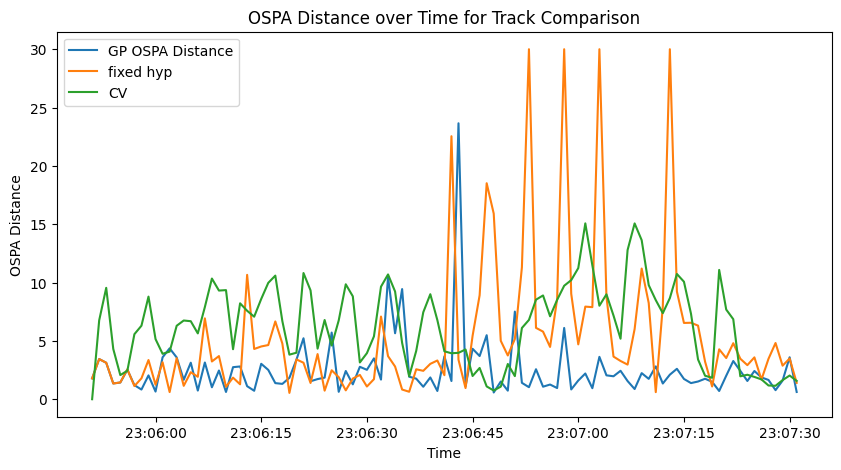

In [113]:
# OSPA distance metric

from matplotlib import pyplot as plt
from stonesoup.metricgenerator.ospametric import OSPAMetric
from stonesoup.metricgenerator.manager import MultiManager
from stonesoup.measures.state import Euclidean

# Set up the OSPA metric generator with specific `mapping` for x, y components
ospa_metric_generator_gp = OSPAMetric(
    c=30, p=1,
    tracks_key='tracks',
    truths_key='truths',
    measure=Euclidean(mapping=[0, WINDOW_SIZE])  # For the [x, y] locations in ground truth and track state vectors
)
ospa_metric_generator_cv = OSPAMetric(
    c=30, p=1,
    tracks_key='tracks',
    truths_key='truths',
    measure=Euclidean(mapping=[0, 2])  # For the [x, y] locations in ground truth and track state vectors
)

# Metric manager to manage the computation of metrics
metric_manager = MultiManager([ospa_metric_generator_gp])
tracks_data = {'tracks': track_adaptive, 'truths': truth}
tracks_data_fixed = {'tracks': track_fixed, 'truths': truth}

truth_cv = GroundTruthPath()
for t in truth:
    state_vector = [t.state_vector[0], 0, t.state_vector[WINDOW_SIZE], 0]
    truth_cv.append(GroundTruthState(state_vector, timestamp=t.timestamp))
metric_manager_cv = MultiManager([ospa_metric_generator_cv])
tracks_data_cv = {'tracks': track_cv, 'truths': truth_cv}

# Generate the metrics
metric_manager.add_data(tracks_data)
metric_data = metric_manager.generate_metrics()

metric_manager.add_data(tracks_data_fixed, overwrite=True)
metric_data_fixed = metric_manager.generate_metrics()

metric_manager_cv.add_data(tracks_data_cv)
metric_data_cv = metric_manager_cv.generate_metrics()

# Retrieve OSPA distances and plot
ospa_distances = [metric.value for metric in metric_data['ospa_generator']['OSPA distances'].value if metric.generator == ospa_metric_generator_gp]
ospa_distances_fixed = [metric.value for metric in metric_data_fixed['ospa_generator']['OSPA distances'].value if metric.generator == ospa_metric_generator_gp]
ospa_distances_cv = [metric.value for metric in metric_data_cv['ospa_generator']['OSPA distances'].value if metric.generator == ospa_metric_generator_cv]
# Plotting OSPA results
plt.figure(figsize=(10, 5))
plt.plot(timesteps[WINDOW_SIZE-1:], ospa_distances, label="GP OSPA Distance")
plt.plot(timesteps[WINDOW_SIZE-1:], ospa_distances_fixed, label="fixed hyp")
plt.plot(timesteps[WINDOW_SIZE-1:], ospa_distances_cv, label="CV")
plt.xlabel("Time")
plt.ylabel("OSPA Distance")
plt.title("OSPA Distance over Time for Track Comparison")
plt.legend()
plt.show()